In [1]:
# Feature engineering and model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

import vectorbt as vbt

# Custom imports to prevent clutter
from helper import get_ohlcv_data
from helper import calculate_triple_barrier_labels
from helper import calculate_train_performance
from helper import calculate_test_performance
from custom_transformers import *

In [2]:
# Specify window sizes for rolling min-max and z-score scaling
window_sizes = [12, 24, 24 * 7]

# Specify the symbol ID
symbol_id = 'BTC_USD_COINBASE'

# Pipeline for feature engineering and modeling
feature_engineering_pipeline = Pipeline([

    # Add block-based features to the dataset
    ('block_features', BlockFeatures()),

    # Add transaction-based features to the dataset
    ('transaction_features', TransactionFeatures()),

    # Add transfer-based features to the dataset
    # ('transfer_features', TransferFeatures()),

    # Add tick-based features to the dataset
    ('tick_features', TickFeatures(symbol_id = symbol_id)),

    # Add order book-based features to the dataset
    # ('order_book_features', OrderBookFeatures(symbol_id = symbol_id)),

    # Add wallet-based features to the dataset
    ('wallet_features', WalletFeatures()),

    # Add rolling min-max scaled features to the dataset
    ('rolling_min_max_scaler', RollingMinMaxScaler(window_sizes)),

    # Add rolling z-score scaled features to the dataset
    ('rolling_z_score_scaler', RollingZScoreScaler(window_sizes)),

    # Add price-based features to the dataset
    ('price_features', PriceFeatures()),

    # Add more feature engineering steps here
    # ...
    # ...

    # Clean NaN/infinity values from the dataset
    ('fill_nan', FillNaN()),

    # Add lagged features to the dataset
    ('lag_features', LagFeatures(lags = [1, 2, 3])),

    # Add time-based features to the dataset
    ('time_features', TimeFeatures())
])

In [3]:
base, quote, exchange = symbol_id.split('_')

ohlcv_1h = get_ohlcv_data(base, quote, exchange)
ohlcv_1h.head()

,price_open,price_high,price_low,price_close,volume_traded
time_period_end,,,,,
2015-01-14 17:00:00,173.93,197.97,110.2,185.91,1.050000
2015-01-14 18:00:00,173.93,197.97,110.2,185.91,1.050000
2015-01-14 19:00:00,186.00,186.00,186.0,186.00,0.015362
2015-01-14 20:00:00,186.00,188.00,120.0,120.00,0.264638
2015-01-14 21:00:00,186.00,188.00,120.0,120.00,0.264638


In [4]:
# Run feature engineering pipeline
X = feature_engineering_pipeline.fit_transform(ohlcv_1h)

# Calculate triple-barrier labels from OHLCV data
y = calculate_triple_barrier_labels(ohlcv_1h, atr_window = 24, max_holding_time = 24)

# Align X and y
X = X[X.index.isin(y.index)]
y = y[y.index.isin(X.index)]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.2)

In [5]:
print(X_train.shape)
X_train.head()

(24576, 1709)


,avg_block_size,block_count,avg_block_reward,avg_difficulty,num_unique_miners,difficulty_adjustment,pct_gas_limit_used,hourly_transaction_volume,daily_transaction_volume,weekly_transaction_volume,...,week,quarter,year,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
2018-05-25 15:00:00,23911.0,286.0,3.017856,3.215260e+15,23.0,6.743151e+13,0.941207,48588.38504,48588.38504,48588.38504,...,21,2,2018,False,False,False,False,False,False,False
2018-05-25 16:00:00,24822.0,289.0,3.014658,3.189676e+15,26.0,4.380492e+13,0.944556,62635.10590,111223.49094,111223.49094,...,21,2,2018,False,False,False,False,False,False,False
2018-05-25 17:00:00,24102.0,317.0,3.016631,3.180510e+15,24.0,3.561841e+13,0.911209,69171.19760,180394.68854,180394.68854,...,21,2,2018,False,False,False,False,False,False,False
2018-05-25 18:00:00,24367.0,284.0,2.978382,3.191682e+15,24.0,6.232377e+13,0.953347,37660.39926,218055.08780,218055.08780,...,21,2,2018,False,False,False,False,False,False,False
2018-05-25 19:00:00,21839.0,311.0,2.977247,3.165741e+15,29.0,6.334586e+13,0.893850,97012.86156,315067.94936,315067.94936,...,21,2,2018,False,False,False,False,False,False,False


In [6]:
# Date range of train and test sets
train_start_date = X_train.index[0]
train_end_date = X_train.index[-1]
test_start_date = X_test.index[0]
test_end_date = X_test.index[-1]

print('Train set date range:', train_start_date, '-', train_end_date)
print('Test set date range:', test_start_date, '-', test_end_date)

Train set date range: 2018-05-25 15:00:00 - 2021-03-14 14:00:00
Test set date range: 2021-03-14 15:00:00 - 2021-11-25 14:00:00


In [7]:
%%time

# Grid search parameters for Random Forest
param_grid_rf = {
    'n_estimators': [50], # Number of trees
    'max_depth': [10], # Maximum depth of each tree
    'min_samples_split': [2], # Minimum number of samples required to split a node
    'min_samples_leaf': [2], # Minimum number of samples required at each leaf node
    'max_features': [0.1], # Random number/percentage of features to consider at each split
}

# Random Forest classifier
rf = RandomForestClassifier(bootstrap = False, random_state = 9 + 10) # Set random state for reproducibility

# Initialize grid search
grid_search = GridSearchCV(
    rf, 
    param_grid_rf, 
    cv = TimeSeriesSplit(n_splits = 5), 
    scoring = 'f1',
    verbose = 1, 
    n_jobs = -1
)

# Execute grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters and best model from grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print()
print('Best parameters: ', best_params)
print()

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best parameters:  {'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

CPU times: user 2min 9s, sys: 376 ms, total: 2min 9s
Wall time: 4min 5s


Train Classification Report

              precision    recall  f1-score   support

        -1.0       0.86      0.99      0.92     14106
         1.0       0.98      0.78      0.87     10470

    accuracy                           0.90     24576
   macro avg       0.92      0.88      0.89     24576
weighted avg       0.91      0.90      0.90     24576

Train Accuracy:  0.8987
Train Precision:  0.9085
Train Recall:  0.8987
Train F1 Score:  0.8966


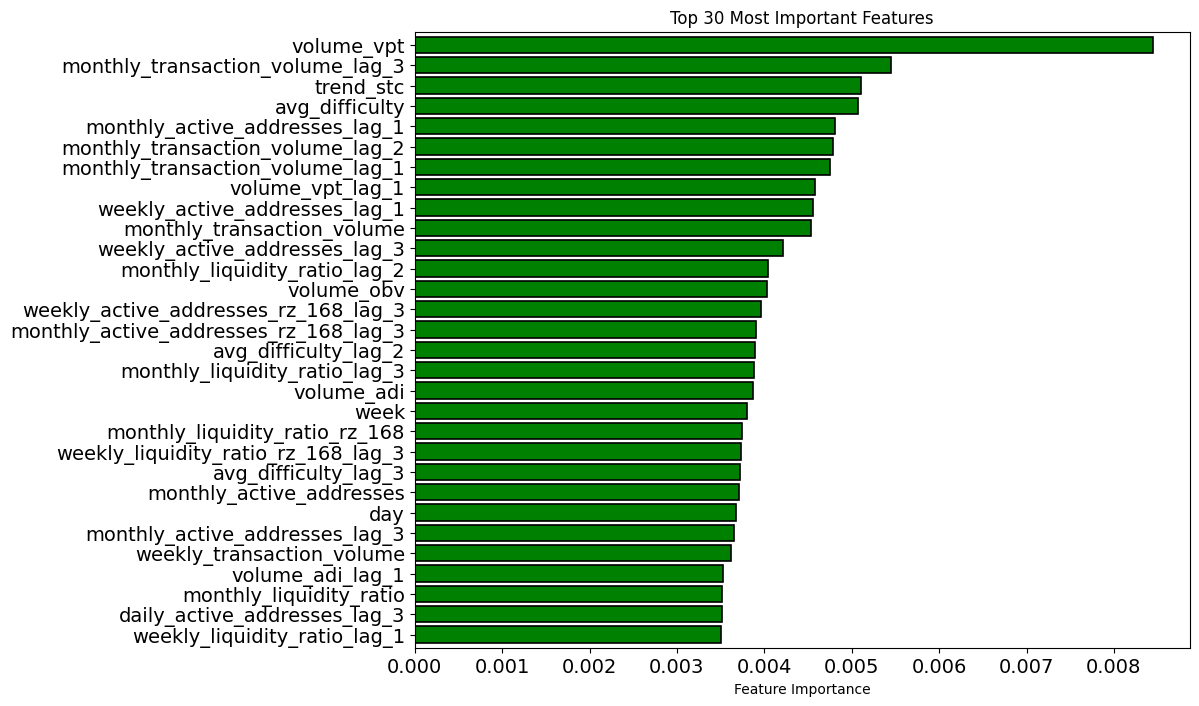

In [8]:
calculate_train_performance(X_train, y_train, best_model)

Test Classification Report

              precision    recall  f1-score   support

        -1.0       0.57      0.56      0.57      3530
         1.0       0.43      0.44      0.43      2614

    accuracy                           0.51      6144
   macro avg       0.50      0.50      0.50      6144
weighted avg       0.51      0.51      0.51      6144

Test Accuracy:  0.509
Test Precision:  0.5115
Test Recall:  0.509
Test F1 Score:  0.5101


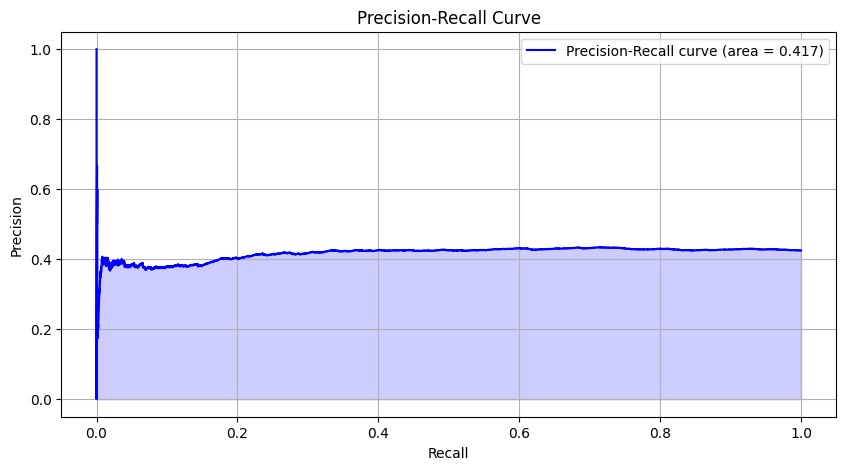

In [9]:
price_data = ohlcv_1h[ohlcv_1h.index.isin(X_test.index)]
atr_data = vbt.ATR.run(price_data.price_high, price_data.price_low, price_data.price_close, window = 24).atr

calculate_test_performance(X_test, y_test, best_model, price_data, atr_data)